In [68]:
"""
    Returns a cleaned X and y dataset to be used for classification.
"""
import os
import cv2
import sys
import numpy as np
from PIL import Image
import tensorflow as tf
from scipy import misc
from matplotlib.image import imread
import matplotlib.pyplot as plt
import keras

import joblib
from sklearn.model_selection import train_test_split, cross_validate

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model


from random import randint
import cv2
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import optimizers



In [69]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [70]:
# Uncomment the following to check whether you have access to a GPU in Google Colab
# See further instructione below.
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') 

[]

In [71]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from packaging import version
import sklearn
import tensorflow as tf
tensorflow_version = tf.__version__
if version.parse(tensorflow_version) < version.parse("2.2.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.2 or later (e.g. 2.4)".format(tensorflow_version))
elif version.parse(tensorflow_version) < version.parse("2.4.0"):
    print("Tensorflow version is <2.4. This will likely work but we recommend updating to 2.4".format(tensorflow_version))
else:
    print("Looks good. You may continue :)")

Looks good. You may continue :)


In [72]:
PATH=r"C:\Users\Jeroen Gijsbers\OneDrive - TU Eindhoven\Uni\Master\Jaar 1\Kwartiel 3\2AMV10 - Visual Analytics\Project\2AMV10-group-16"
PATH_m = r"/content/drive/MyDrive/-Univ/2AMV10 Visual Analytics/2AMV10-group-16"
IMG_SIZE  = 160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
IMAGE_CHANNEL = 3
stop_training = False

Helper functions

In [73]:
def process_img(sample):
  """Function to process the large images to a more handle-able format
  
     returns: """
  try:
    # print(sample.shape)
    sample = np.array(sample)
    sample = sample / 255.
    sample = cv2.resize(sample, (IMG_SIZE, IMG_SIZE))
    return sample.reshape(IMG_SIZE, IMG_SIZE, IMAGE_CHANNEL)
  except ValueError or AttributeError:
    print(sample, "returned an error")


def read_data():
    """
        Reads the images and returns them as arrays X and y

        returns: X      array containing np-array-representation of images
                 y      array containing corresponding labels
    """
    #print(os.curdir)
    #os.chdir('../data/trainingData/TrainingImages')
    X = []
    y = []
    labels = []
    sys.path.insert(0, PATH_m)

    path = "/content/drive/MyDrive/-Univ/2AMV10/2AMV10-group-16/data/trainingData/TrainingImages"
    i = 0
    limit = 100000
    for label in [name for name in os.listdir(path) if os.path.isdir(f"{path}/{name}")]:
        print(label)
        labels.append(label)
        for image in [name for name in os.listdir(f"{path}/{label}")]:
            if image.endswith('.db'):
              pass
            else:
              # print(f"{path}/{label}/{image}")
              X.append(process_img(cv2.imread(f"{path}/{label}/{image}")))
              # print(label)
              y.append(label)
              i+= 1
            if i == limit:
                break
        if i == limit:
            break
    return np.array(X), y, labels#.reshape(50, 256*256), y, labels


# Helper function for user feedback
def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

def show_images(grayscale=False, display_test=False):
        """
            Shows 10 random images from the dataset
        """
        def plot_images(X, y, grayscale=False, display_test=False):
            fig, axes = plt.subplots(1, len(X), figsize=(15,30))
            for n in range(len(X)):
                if grayscale:
                    axes[n].imshow(X[n], cmap='gray')
                else:
                    axes[n].imshow(X[n])
                # print(f"1: {y[n]}")
                # print(f"2: {np.argmax(y[n])} ")
                # print(f"3: {self.labels[:5]}")
                # print(f"4: {self.labels[np.argmin(y[n])]}")
                axes[n].set_xlabel(y[n])
                axes[n].set_xticks(()), axes[n].set_yticks(())
            plt.show()

        images = [randint(0,len(X_train)-1) for i in range(5)]
        # print(images)
        X_random = [X_train[i] for i in images]
        y_random = [y_train[i] for i in images]
        plot_images(X_random, y_random)

        if display_test:
            images = [randint(0,len(X_test)-1) for i in range(5)]
            X_random = [X_test[i] for i in images]
            y_random = [y_test[i] for i in images]
            plot_images(X_random, y_random)


In [67]:
from numpy import asarray
from numpy import save, load
X, y, labels = read_data()



legoBracelet
metalKey
paperPlate
spiderRing
vancouverCards
voiceRecorder
silverStraw
redBow
turtle
pumpkinNotes
rainbowPens
trophy
stickerBox
rubiksCube
noisemaker
partyFavor
miniCards
pinkEraser
yellowBag
redWhistle
plaidPencil
yellowBalloon
redDart
sign
pinkCandle
birdCall
blueSunglasses
brownDie
cactusPaper
canadaPencil
carabiner
cloudSign
cowbell
cupcakePaper
eyeball
foamDart
gClamp
giftBag
glassBead
gyroscope
hairClip
hairRoller
lavenderDie


In [86]:
# save('X.npy', X)
# save('y.npy', y)
# save('labels.npy', labels)

X = load('/content/drive/MyDrive/-Univ/2AMV10/2AMV10-group-16/X.npy')
y = load('/content/drive/MyDrive/-Univ/2AMV10/2AMV10-group-16/y.npy')
# labels = load('/content/drive/MyDrive/-Univ/2AMV10/2AMV10-group-16/labels.npy')

# print(X.shape, y.shape)
# y=np.argmax(y,axis=1)

array(['legoBracelet', 'legoBracelet', 'legoBracelet', 'legoBracelet',
       'legoBracelet', 'legoBracelet', 'legoBracelet', 'legoBracelet',
       'legoBracelet', 'legoBracelet', 'legoBracelet', 'legoBracelet',
       'metalKey', 'metalKey', 'metalKey', 'metalKey', 'metalKey',
       'metalKey', 'metalKey', 'metalKey', 'metalKey', 'metalKey',
       'metalKey', 'metalKey', 'paperPlate', 'paperPlate', 'paperPlate',
       'paperPlate', 'paperPlate', 'paperPlate', 'paperPlate',
       'paperPlate', 'paperPlate', 'paperPlate', 'paperPlate',
       'paperPlate', 'spiderRing', 'spiderRing', 'spiderRing',
       'spiderRing', 'spiderRing', 'spiderRing', 'spiderRing',
       'spiderRing', 'spiderRing', 'spiderRing', 'spiderRing',
       'spiderRing', 'vancouverCards', 'vancouverCards', 'vancouverCards',
       'vancouverCards', 'vancouverCards', 'vancouverCards',
       'vancouverCards', 'vancouverCards', 'vancouverCards',
       'vancouverCards', 'vancouverCards', 'vancouverCards',
       

In [88]:
# Data preprocessing


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

X_train = np.repeat(X_train, 10, axis=0)
y_train = np.repeat(y_train, 10, axis=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)


labels = pd.unique(y_train)


le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

le.fit(y_val)
y_val = le.transform(y_val)

le.fit(y_test)
y_test = le.transform(y_test)

le.fit(y)
y = le.transform(y)


classes = dict(zip(pd.unique(y_train), labels))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [89]:
y_train.shape

(3296, 43)

In [90]:
y_val.shape

(824, 43)

In [91]:
y_test.shape


(104, 43)

Show a random image and it's associated label

gClamp


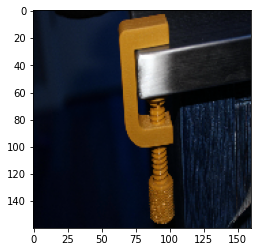

In [92]:

plt.imshow(X_train[5])
print(classes[np.argmax(y_train[5])])

redWhistle


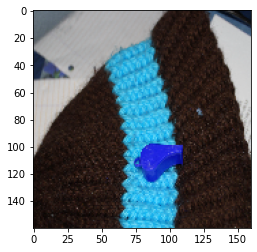

In [93]:
plt.imshow(X_test[5])
print(classes[np.argmax(y_test[5])])

In [94]:
evaluation_split = np.array(X_train), np.array(X_val), np.array(y_train), np.array(y_val)

In [95]:
print(y_train.shape[1])
print(X_train.shape, y_train.shape)

43
(3296, 160, 160, 3) (3296, 43)


In [96]:
print(y_val.shape[1])
print(X_val.shape, y_val.shape)

43
(824, 160, 160, 3) (824, 43)


In [97]:
print(y_test.shape[1])
print(X_test.shape, y_test.shape)

43
(104, 160, 160, 3) (104, 43)


In [98]:
y = to_categorical(y)

In [99]:
y_val[5]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

redWhistle


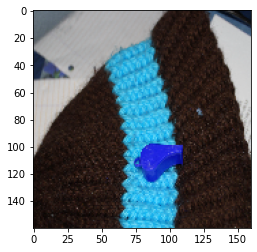

In [100]:
plt.imshow(X_test[5])
print(classes[np.argmax(y_test[5])])

In [101]:
def augment_data():
    """ Augments the data and returns a generator and the validation data and labels
    """
    # Boilerplate code. You can change this however you like.
    generator = ImageDataGenerator(
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rotation_range=360
                                   ).flow(X_train, y_train)
    return generator, X_test, y_test

In [189]:
# Toy usage example
from tensorflow.keras import models
from tensorflow.keras import layers 
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

mobilenet = MobileNetV2(input_shape=(160,160,3),
                    alpha=1.0,
                    include_top=False,
                    weights="imagenet",
                    input_tensor=None,
                    pooling=None
                    )
    
def build_toy_model():
    model = models.Sequential()

    model.add(mobilenet)
    # I tried unfreezing in the function below but it didnt work well
    for layer in model.layers[:1]:
      layer.trainable = False

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.35))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.45))
    model.add(layers.Dense(y_val.shape[1], activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model


# First build and store


In [103]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               327936    
                                                                 
 dropout_4 (Dropout)         (None, 256)              

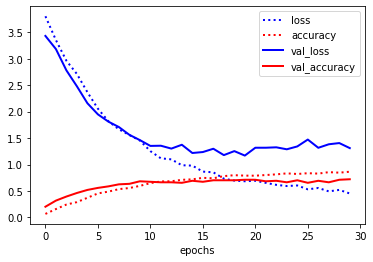

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               327936    
                                                                 
 dropout_4 (Dropout)         (None, 256)              

In [104]:
run_evaluation("toy_example", build_toy_model, augment_data(), 
               PATH_m, generator=True, epochs=100, steps_per_epoch=30)

In [105]:
from sklearn.metrics import accuracy_score

def evaluate_model(name):
    model = load_model_from_file(PATH_m, name, ".h5")
    preds = np.argmax(model.predict(X_test), axis=1)
    y_test_c = np.argmax(y_test,axis=1)
    print(f"The accuracy is: {accuracy_score(preds, y_test_c)}")
    return accuracy_score(preds, y_test_c)
test_accuracy_2_1 = evaluate_model("toy_example")


The accuracy is: 0.7211538461538461


In [106]:
model = load_model_from_file(PATH_m, 'toy_example', '.h5')

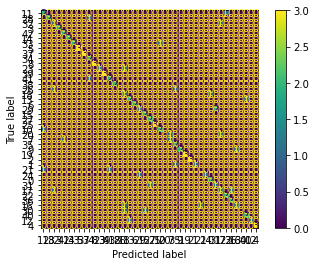

In [107]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix():
    model = load_model_from_file(PATH_m, "toy_example", ".h5")
    preds = np.argmax(model.predict(X_test), axis=1)
    y_test_c = np.argmax(y_test,axis=1)

    cm = ConfusionMatrixDisplay(confusion_matrix(y_test_c, preds), display_labels=classes)
    cm.plot()
    plt.show()
plot_confusion_matrix()

redWhistle


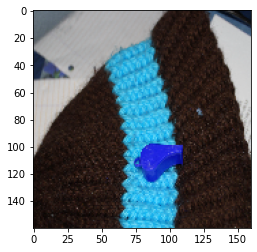

In [108]:
plt.imshow(X_test[5])
print(classes[np.argmax(y_test[5])])

In [ ]:
def plot_misclassifications():
    model = load_model_from_file(PATH_m, "toy_example", ".h5")
    y_pred = model.predict(X_test)
    misclassified_samples = np.nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))[0]

    fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
    print(misclassified_samples[:5])
    for nr, i in enumerate(misclassified_samples[:5]):
        axes[nr].imshow(X_test[i])
        print(np.argmax(y_pred[i]), np.argmax(y_test[i]))
        axes[nr].set_xlabel("Predicted: %s,\n Actual : %s" % (classes[np.argmax(y_pred[i])],classes[np.argmax(y_test[i])]))
        axes[nr].set_xticks(()), axes[nr].set_yticks(())

    plt.show()


plot_misclassifications()

stickerBox


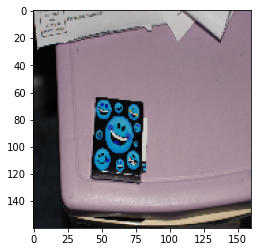

In [110]:
plt.imshow(X_test[0]);
print(classes[np.argmax(y_test[0])])


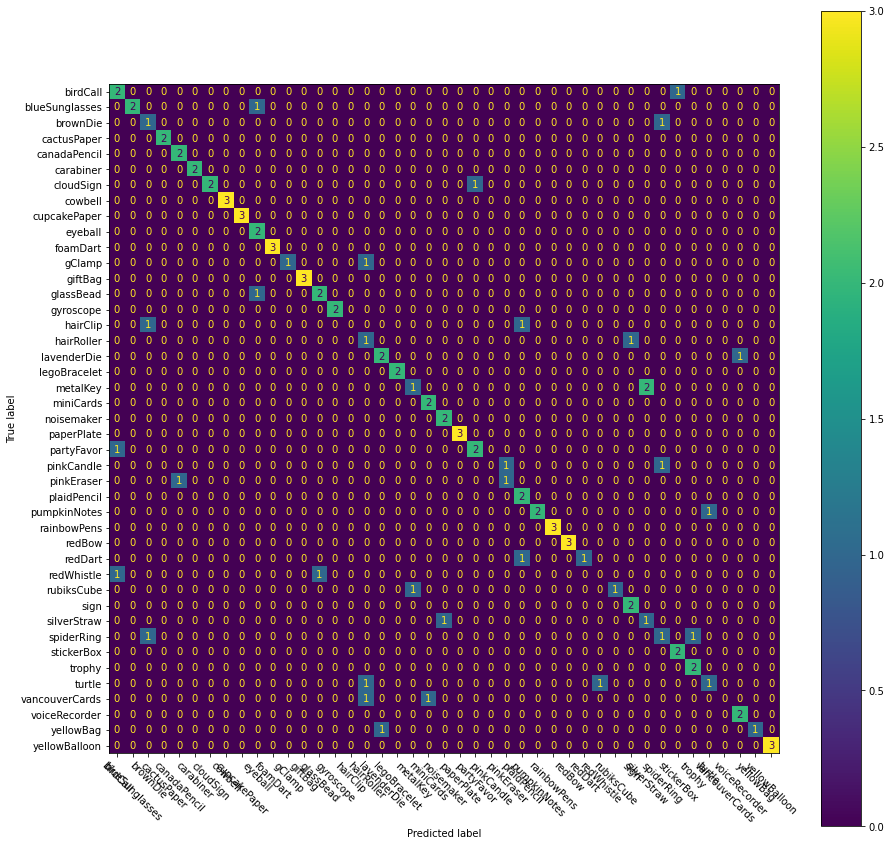

In [111]:
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def preds_to_json(test_set=X_test, plot=True):
  """
  Function does not return anything but makes a new file, plots if you want it to
  """
  
  X_test = test_set
  model = load_model_from_file(PATH_m, "toy_example", ".h5")
  preds = model.predict(X_test)

  a2 = np.argmax(preds, axis=1)
  a1 = np.argmax(y_test, axis=1)
  
  a_names = np.vectorize(classes.get)(a1)
  b_names = np.vectorize(classes.get)(a2)

  data = confusion_matrix(a_names, b_names)

  manual_dict = {}
  i = 0
  for col in data:
    colname = np.unique(a_names)[i]
    # print(colname)

    temp_dict = {str(colname) : data[i].tolist()}
    # print(temp_dict)
    manual_dict.update(temp_dict)
    i+=1

  with open('cm.json', 'w') as file:
      json.dump(manual_dict, file)

  if plot:
    cm = ConfusionMatrixDisplay(confusion_matrix(a_names, b_names), display_labels=np.unique(a_names))
    fig, ax = plt.subplots(figsize=(15,15))
    cm.plot(ax=ax)
    plt.xticks(rotation = -45)
    plt.show()

preds_to_json()

In [112]:
print(PATH_m)

/content/drive/MyDrive/-Univ/2AMV10 Visual Analytics/2AMV10-group-16


In [113]:
import time 
def read_test():

  """
        Reads the images and returns them as arrays X and y

        returns: X_t      array containing np-array-representation of images
                 y      array containing corresponding labels
  """

  #print(os.curdir)
  #os.chdir('../data/trainingData/TrainingImages')
  X_t = []
  captions = []
  person_order = []
  person_n = []
  sys.path.insert(0, PATH_m)
  t_0 = time.perf_counter()
  path = "/content/drive/MyDrive/-Univ/2AMV10/2AMV10-group-16/data"
  i = 0
  limit = 100000
  for label in [name for name in os.listdir(path) if os.path.isdir(f"{path}/{name}")]:
      print(label)
      if not 'Person' in label:
        break
      person_order.append(label)
      t_1 = time.perf_counter()
      for image in [name for name in os.listdir(f"{path}/{label}")]:
          if image.endswith('.db') or image.endswith('.txt'):
            pass
            # skip captions for now
            # TODO get text out of file instead of filename
            # with open(f"{path}/{label}/{image}", "r") as f:
            #   print(image)
            #   print(f.readlines())
            #   captions.append(f.readlines())
          #X.append(cv2.imread(f"{path}/{label}/{image}"))
          else:
            person_n.append(label)
            # print(image)
            X_t.append(process_img(cv2.imread(f"{path}/{label}/{image}")))
            t_2 = time.perf_counter()
            print(f"Doing image {image} took {t_2-t_1}")
            # print(label)
            i+= 1
          if i == limit:
              break
      if i == limit:
          break
      t_4 = time.perf_counter()
      print(f"Doing person : {label} took {t_4 - t_1}")
  t_3 = time.perf_counter()
  print(f"Done in {t_3-t_0}")  
  return np.array(X_t), captions, person_n#.reshape(50, 256*256), y, labels


X_t, captions, person_n = read_test()

Person40
Doing image Person40_1.jpg took 0.3594730559998425
Doing image Person40_10.jpg took 1.8616974010001286
Doing image Person40_2.jpg took 2.1238804330000676
Doing image Person40_3.jpg took 2.365164392999759
Doing image Person40_4.jpg took 2.6008605160000116
Doing image Person40_5.jpg took 3.422258624999813
Doing image Person40_6.jpg took 4.38320516199974
Doing image Person40_7.jpg took 5.1134370700001455
Doing image Person40_8.jpg took 5.958439402999829
Doing image Person40_9.jpg took 6.809385805000147
Doing person : Person40 took 6.811372057999961
Person38
Doing image Person38_1.jpg took 0.48460189299976264
Doing image Person38_10.jpg took 1.00415553799985
Doing image Person38_11.jpg took 1.4635165439999582
Doing image Person38_12.jpg took 1.9362547370001266
Doing image Person38_13.jpg took 2.3851728039999216
Doing image Person38_14.jpg took 2.741673967999759
Doing image Person38_15.jpg took 3.1951252680000835
Doing image Person38_16.jpg took 3.620692222999878
Doing image Person

In [114]:
X_t[0]

array([[[0.07058824, 0.05490196, 0.07768076],
        [0.07058824, 0.05490196, 0.0745098 ],
        [0.06666667, 0.05098039, 0.07058824],
        ...,
        [0.06813725, 0.06813725, 0.06813725],
        [0.06813725, 0.06813725, 0.06813725],
        [0.08114277, 0.08114277, 0.08114277]],

       [[0.07005208, 0.05730699, 0.06862745],
        [0.06852022, 0.05675551, 0.06459865],
        [0.06567096, 0.05390625, 0.06174939],
        ...,
        [0.06101409, 0.06101409, 0.06101409],
        [0.05735294, 0.05735294, 0.05735294],
        [0.06004902, 0.06004902, 0.06004902]],

       [[0.06887255, 0.06102941, 0.05890012],
        [0.06251532, 0.05467218, 0.05393689],
        [0.05503983, 0.05503983, 0.05503983],
        ...,
        [0.05637255, 0.05637255, 0.05637255],
        [0.06127451, 0.06127451, 0.06127451],
        [0.06813725, 0.06813725, 0.06813725]],

       ...,

       [[0.42617953, 0.4810815 , 0.55166973],
        [0.42915135, 0.48405331, 0.55464154],
        [0.39805453, 0

In [115]:
X_train[0]

array([[[0.19360784, 0.114     , 0.09792157],
        [0.22760786, 0.1617255 , 0.14996079],
        [0.25843138, 0.18235295, 0.17843138],
        ...,
        [0.13215686, 0.08509804, 0.0772549 ],
        [0.11517674, 0.06419635, 0.05635321],
        [0.12039292, 0.07058824, 0.0627451 ]],

       [[0.29439211, 0.24098035, 0.23219603],
        [0.26058824, 0.17113725, 0.16380394],
        [0.19352942, 0.11882353, 0.10235294],
        ...,
        [0.12901961, 0.0745098 , 0.06666667],
        [0.12937289, 0.0783925 , 0.07054936],
        [0.12498047, 0.08027305, 0.08027305]],

       [[0.17117647, 0.10745098, 0.10490196],
        [0.18392157, 0.12529412, 0.10117648],
        [0.2       , 0.13921569, 0.14901961],
        ...,
        [0.16176471, 0.10294118, 0.09509804],
        [0.1217649 , 0.07078451, 0.06294137],
        [0.11960401, 0.07254519, 0.07254519]],

       ...,

       [[0.2962745 , 0.24039215, 0.2272549 ],
        [0.21058822, 0.15176469, 0.14039214],
        [0.18039216, 0

In [117]:
yt_pred = model.predict(X_t)

In [119]:
predsnames = np.vectorize(classes.get)(np.argmax(yt_pred, axis=1))

In [120]:
person_n[0]

'Person40'

yellowBag


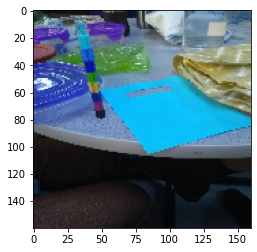

In [131]:
plt.imshow(X_t[20])
print(predsnames[20])

In [132]:
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def test_to_json(test_set=X_t, plot=True):
  """
  Function does not return anything but makes a new file, plots if you want it to
  """
  
  X_test = test_set
  model = load_model_from_file(PATH_m, "toy_example", ".h5")
  preds = model.predict(X_test)

  
  a_names = np.vectorize(classes.get)(np.argmax(preds, axis=1))


  manual_dict = {}
  i = 0
  for col in data:
    colname = np.unique(a_names)[i]
    # print(colname)

    temp_dict = {str(colname) : data[i].tolist()}
    # print(temp_dict)
    manual_dict.update(temp_dict)
    i+=1

  with open('predsxt.json', 'w') as file:
      json.dump(manual_dict, file)


preds_to_json(plot=False)

In [133]:
model = load_model_from_file(PATH_m, "toy_example", ".h5")
preds = model.predict(X_t)


a_names = np.vectorize(classes.get)(np.argmax(preds, axis=1))
a_names.shape

a_numbers = np.argmax(preds, axis=1)
print(a_numbers)


[17  0 41  9  9 37 11 17 17 25 23 23  0 40 18 23 30  1 28 41 41  5 37 31
 17  7 16 20 20 20 40 37 26 14  9 35  9 10  8 26 27 29  0  4 20  9  8  9
 15 23  9  9  9 20 20 26 28 23 31 21 16 18 38  6 25 23 23 30 19 23 30 14
 23 23 40 23  9 29 34 20  1 18 35 30 26 23 23 18 31  8  8  9 16 18 18 23
  1 17 30 31 31 24  7 17  1  8  9 41  8  9 23 17 23 26 23 19  9  9 23  8
  1 20  9  9 11 11 17 20 11 37 18 40 20 26 26 27  6  2  0  1  9 20 23 35
 24 20 39 38 28 19 27  6 24  1 23 23 17 25 23 41 35  8  1  9 41 23 34 25
  4 23 33 34 12 14  4 34 37  0 41 37 33  1 23  4 39 37 37  9 35 37 19 23
  5 37 11 23  9 30 15 24 35 15 15 33 15 23 34 19 34  8  8 30 30 30 29 23
 23 23  3 23 23 25 35 34 34 34 15 34  1 17 16 23 34 26 38  1 19 19  9  9
 29  9 32 23  2 28 29 29 24  9  9 37 29 15 23 32 23 23 24 37 29 34 35 23
 20  1 23 23 29 10 17 23 17 17 13 29 41  7 23 23 23  9 35 35 34 36 16 25
 23  0 24 15  8 23  1 15 29 37 37 23 37 17 29  8 37 25 38  1 34 33  1 14
 15 16 15  0 22 24  4 20 16 33 20 22  0  1 37 22 37

In [123]:
classes

{0: 'birdCall',
 1: 'blueSunglasses',
 2: 'brownDie',
 3: 'cactusPaper',
 4: 'canadaPencil',
 5: 'carabiner',
 6: 'cloudSign',
 7: 'cowbell',
 8: 'cupcakePaper',
 9: 'eyeball',
 10: 'foamDart',
 11: 'gClamp',
 12: 'giftBag',
 13: 'glassBead',
 14: 'gyroscope',
 15: 'hairClip',
 16: 'hairRoller',
 17: 'lavenderDie',
 18: 'legoBracelet',
 19: 'metalKey',
 20: 'miniCards',
 21: 'noisemaker',
 22: 'paperPlate',
 23: 'partyFavor',
 24: 'pinkCandle',
 25: 'pinkEraser',
 26: 'plaidPencil',
 27: 'pumpkinNotes',
 28: 'rainbowPens',
 29: 'redBow',
 30: 'redDart',
 31: 'redWhistle',
 32: 'rubiksCube',
 33: 'sign',
 34: 'silverStraw',
 35: 'spiderRing',
 36: 'stickerBox',
 37: 'trophy',
 38: 'turtle',
 39: 'vancouverCards',
 40: 'voiceRecorder',
 41: 'yellowBag',
 42: 'yellowBalloon'}

In [124]:
len(person_n)

907

In [134]:
from itertools import groupby

alist = [i for i, j in groupby(person_n)]

blist = a_names

listofpreds = list(zip(person_n, a_numbers))

In [135]:
results = {}                              # use a normal dictionary for our output
for k, v in listofpreds:                    # the keys may be duplicates
    results.setdefault(k[6:], []).append(int(v))
results

{'1': [20, 34, 36, 9, 23, 19, 15, 23, 42, 31, 23],
 '10': [24,
  9,
  17,
  3,
  26,
  4,
  26,
  34,
  13,
  8,
  37,
  26,
  1,
  24,
  29,
  35,
  9,
  24,
  29,
  0,
  24,
  23,
  5,
  42,
  9],
 '11': [24,
  15,
  33,
  33,
  26,
  15,
  8,
  24,
  33,
  34,
  34,
  33,
  24,
  8,
  19,
  35,
  0,
  26,
  17,
  17,
  19,
  23,
  8,
  23,
  15,
  15,
  15,
  15,
  15,
  33],
 '12': [25, 21, 40, 23, 24, 15, 20, 41, 20, 19, 9, 19, 21, 9, 21],
 '13': [22,
  1,
  15,
  37,
  8,
  22,
  17,
  22,
  0,
  15,
  9,
  8,
  14,
  9,
  24,
  36,
  0,
  20,
  23,
  1,
  9,
  22,
  8,
  9,
  22,
  8,
  8,
  23,
  20,
  17,
  1,
  20,
  15,
  19,
  9,
  40,
  22],
 '14': [8, 26, 27, 29, 0, 4, 20, 9, 8, 9, 15, 23, 9, 9, 9, 20, 20, 26, 28],
 '15': [21, 23, 17, 15, 40, 21, 33, 33, 23, 23, 17, 41, 9],
 '16': [17, 23, 23, 17, 17, 23, 9, 23, 41, 0],
 '17': [23,
  31,
  21,
  16,
  18,
  38,
  6,
  25,
  23,
  23,
  30,
  19,
  23,
  30,
  14,
  23,
  23,
  40,
  23,
  9,
  29,
  34,
  20,
  1,
  18,
 

In [136]:
with open('predsxtnumerical.json', 'w') as file:
      json.dump(results, file)
      
      

In [137]:
a_numbers = [int(x) for x in a_numbers]
# a_numbers

[17,
 0,
 41,
 9,
 9,
 37,
 11,
 17,
 17,
 25,
 23,
 23,
 0,
 40,
 18,
 23,
 30,
 1,
 28,
 41,
 41,
 5,
 37,
 31,
 17,
 7,
 16,
 20,
 20,
 20,
 40,
 37,
 26,
 14,
 9,
 35,
 9,
 10,
 8,
 26,
 27,
 29,
 0,
 4,
 20,
 9,
 8,
 9,
 15,
 23,
 9,
 9,
 9,
 20,
 20,
 26,
 28,
 23,
 31,
 21,
 16,
 18,
 38,
 6,
 25,
 23,
 23,
 30,
 19,
 23,
 30,
 14,
 23,
 23,
 40,
 23,
 9,
 29,
 34,
 20,
 1,
 18,
 35,
 30,
 26,
 23,
 23,
 18,
 31,
 8,
 8,
 9,
 16,
 18,
 18,
 23,
 1,
 17,
 30,
 31,
 31,
 24,
 7,
 17,
 1,
 8,
 9,
 41,
 8,
 9,
 23,
 17,
 23,
 26,
 23,
 19,
 9,
 9,
 23,
 8,
 1,
 20,
 9,
 9,
 11,
 11,
 17,
 20,
 11,
 37,
 18,
 40,
 20,
 26,
 26,
 27,
 6,
 2,
 0,
 1,
 9,
 20,
 23,
 35,
 24,
 20,
 39,
 38,
 28,
 19,
 27,
 6,
 24,
 1,
 23,
 23,
 17,
 25,
 23,
 41,
 35,
 8,
 1,
 9,
 41,
 23,
 34,
 25,
 4,
 23,
 33,
 34,
 12,
 14,
 4,
 34,
 37,
 0,
 41,
 37,
 33,
 1,
 23,
 4,
 39,
 37,
 37,
 9,
 35,
 37,
 19,
 23,
 5,
 37,
 11,
 23,
 9,
 30,
 15,
 24,
 35,
 15,
 15,
 33,
 15,
 23,
 34,
 19,
 34,
 8,
 8,
 3

In [138]:
a_numbers = list(a_numbers)

In [140]:
listofpreds = list(zip(person_n, a_numbers))

In [141]:
def save_to_json(data, filename):
  with open(str(filename+'.json'), 'w') as file:
        json.dump(data, file)

In [142]:
save_to_json(listofpreds, 'predsxttuples')

In [211]:
from tensorflow.keras import models

# print(mobilenet.summary())
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=mobilenet.input, outputs=mobilenet.get_layer('Conv1').output)

# This will return a list of 5 Numpy arrays:
# one array per layer activation



KerasTensor(type_spec=TensorSpec(shape=(None, 43), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")


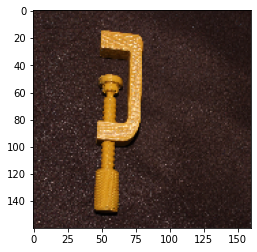

In [186]:
plt.imshow(X_train[0])

print(mobilenet.output[:])

(1, 80, 80, 32)


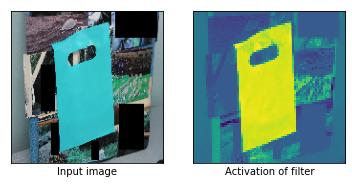

In [231]:
activations = activation_model.predict(X_train[15].reshape(-1, 160, 160, 3))
first_layer_activation = activations
print(first_layer_activation.shape)

# print(first_layer_activation)

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[15])
ax2.matshow(first_layer_activation[0, :, :,2], cmap='viridis')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_xlabel('Input image')
ax2.set_xlabel('Activation of filter');

In [ ]:
|

In [182]:
plot_activations(1, activations)